# Correlação Pearson

### Correlação:
Relacionamento linear entre duas variáveis. 

### Correlação Pearson
É a medida de força dessa relação, variando de -1 a 1. Valores negativos indicam relação negativa e valores positivos indicam relação positiva.

<figure>
  <img
  src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png"
  alt="Pearson Correlation Example Plots">	
  <figcaption>Source:
    <a href="https://en.wikipedia.org/wiki/Pearson_correlation_coefficient" target="_blank">
      Wikipedia
    </a>
  </figcaption>
</figure>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from pymongo import MongoClient
from cmath import sqrt
from scipy.stats import pearsonr
%matplotlib inline
sns.set(color_codes=True)

## Dados

Vamos utilizar dados da base `movies` e vamos olhar a relação entre `imdb.votes` e `imdb.rating` e determinar se há correlação.


In [2]:
movies = MongoClient()['nosqlba']['movies']

In [3]:
pipeline = [
    {
        "$match": {
            "imdb.rating": { "$gt": 0 },
            "imdb.votes": { "$gt": 0}
        }
    },
    {
        "$project": {
            "_id": 0,
            "rating": "$imdb.rating",
            "votes": "$imdb.votes"
        }
    }
]

In [5]:
df = pd.DataFrame.from_dict(list(movies.aggregate(pipeline)))

In [6]:
df.head()

,rating,votes
0,6.7,566
1,6.2,1189
2,5.9,988
3,7.1,2554
4,5.9,1669


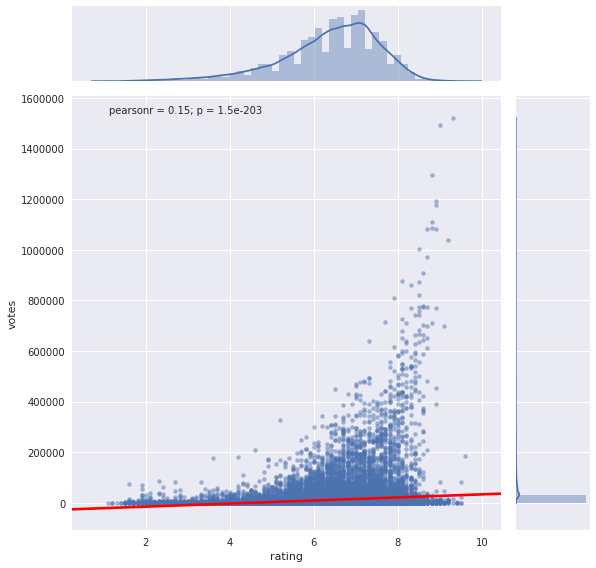

In [7]:
sns.jointplot(x="rating", y="votes", data=df, kind='reg',
                  joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': { 'alpha': 0.5, 's': 20}}, size=8 )

Utilizando a função `pearsonr`, da biblioteca `scipy.stats`:

In [8]:
p = pearsonr(df['rating'], df['votes'])
print(f"{round(p[0], 4)}")

0.1464


Excelente! Porém essa operação é mais lenta do que pode ser devido, em especial ao tráfego de dados do banco para a nossa aplicação.

E podemos fazer todo esse trabalho dentro do próprio servidor do MongoDB, reduzindo esse overhead.

## Calculando a correlação no MongoDB

### A Fórmula

![Pearson's Rho Single Pass Formula](https://s3.amazonaws.com/special-partnerships/coursera/pearson.gif)


### O Trabalho

Para calcular a correlação, precisamos de obter vários valores para serem utilizados posteriormente:

* Calcular a média para `X` e a média para `Y`.
* Para cada `X`, subtrair sua média, obtendo o que chamaremos de `x`.
* Para cada `Y`, subtrair sua média, obtendo o que chamaremos de `y`.
* Para cada par de valores, multiplicar `x` e `y`, obtendo `xy`.
* Para cada `x` e cada `y`, calcular o quadrado, obtendo `x2` e `y2`.

Vamos calcular todas essas variáveis dentro de um **aggregation framework pipeline** e vamos designar a correlação como `m` 


In [9]:
X = '$imdb.rating'
Y = '$imdb.votes'

In [10]:
elems = { "$sum": 1 }
sum_x = { "$sum": X }
sum_y = { "$sum": Y }
sum_x2 = { "$sum": { "$multiply": [X, X] } }
sum_y2 = { "$sum": { "$multiply": [Y, Y] } }
sum_xy = { "$sum": { "$multiply": [X, Y] } }

all_sums = {
    "$group": {
        "_id": None,
        "elems": elems,
        "sum_x": sum_x,
        "sum_y": sum_y,
        "sum_x2": sum_x2,
        "sum_y2": sum_y2,
        "sum_xy": sum_xy
    }
}

In [11]:
product_sum_x_sum_y = { "$multiply": ["$sum_x", "$sum_y"] }
product_sum_xy_elems = { "$multiply": ["$sum_xy", "$elems"] }
top = { "$subtract": [ product_sum_xy_elems, product_sum_x_sum_y]}

In [12]:
product_sum_x2_elems = { "$multiply": ["$sum_x2", "$elems"] }
sum_x_2 = { "$multiply": ["$sum_x", "$sum_x"] }
bottom_left = { "$subtract": [ product_sum_x2_elems, sum_x_2]}

In [13]:
product_sum_y2_elems = { "$multiply": ["$sum_y2", "$elems"] }
sum_y_2 = { "$multiply": ["$sum_y", "$sum_y"] }
bottom_right = { "$subtract": [product_sum_y2_elems, sum_y_2] }

In [14]:
bottom = { "$sqrt": { "$multiply": [bottom_left, bottom_right] } }
correlation = { 
    "$project": {
        "m": { "$divide": [top, bottom] }
    }
}

In [15]:
pipeline = [
    {
        "$match": {
            "imdb.rating": { "$gt": 0 },
            "imdb.votes": { "$gt": 0}
        }
    },
    all_sums,
    correlation
]

In [16]:
result = list(movies.aggregate(pipeline))
print(f"""
p = {round(p[0], 4)} (from scipy)
m = {round(result[0]['m'], 4)} (from MongoDB)
""")


p = 0.1464 (from scipy)
m = 0.1464 (from MongoDB)

